In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import *

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import dal
warnings.filterwarnings("ignore")

snow_runner = dal.SnowflakeRunner()

In [3]:
conversations_public = snow_runner.get_data_raw('queries/conversations_public.sql')
df = pd.DataFrame(conversations_public)

In [4]:
project_users = snow_runner.get_data_raw('queries/project_to_staff.sql')
df_project_users = pd.DataFrame(project_users)

In [5]:
dict_cursor_roles = snow_runner.get_data_raw('queries/user_roles.sql')

In [6]:
projects = list(set(df.PROJECT_ID))
list_net = []
for project in  projects:
    user_list = list(set(df[df.PROJECT_ID == project].USER_ID))
    data = list(filter(lambda x: x['PROJECT_ID'] == project, conversations_public))
    roles = list(filter(lambda x: x['USER_ID'] in user_list, dict_cursor_roles))
    list_net.append({'project_id':project, 'network': build_network(data, roles)})

In [7]:
project_centrality = []
for project in projects:
    network = [i for i in filter(lambda x: x['project_id'] == project, list_net)][0]['network']
    centrality_dict = nx.eigenvector_centrality(network, weight='weight', max_iter=1000)
    centrality_list = [{key:value} for key, value in centrality_dict.items()]
    for i in centrality_list:
        for user, centrality_ in i.items():
            
            project_centrality.append({'project_id': project, 'user_id': user, 'centrality': centrality_})

In [8]:
df_user_centrality = pd.DataFrame(project_centrality)
df_project_users_filtered = df_project_users[df_project_users.PROJECT_ID.isin(projects)]

In [9]:
df_centrality = df_project_users_filtered.merge(df_user_centrality, right_on=['project_id', 'user_id'], left_on=['PROJECT_ID', 'USER_ID'], how = 'left')
df_centrality= df_centrality[pd.notnull(df_centrality.project_id)]
df_centrality = df_centrality[['PROJECT_ID', 'USER_ID', 'centrality','MAPPING_TYPE']].fillna(0)
df_centrality_cpms = df_centrality[df_centrality.MAPPING_TYPE == 'CPM']

In [10]:
project_on_time = snow_runner.get_data_raw('queries/project_on_time.sql')
df_project_on_time = pd.DataFrame(project_on_time)

In [11]:
df_cpms_full = df_centrality_cpms.merge(df_project_on_time, how = 'left', right_on='PROJECT_ID', left_on='PROJECT_ID')
df_cpms_full_filtered = df_cpms_full[pd.notnull(df_cpms_full.IS_ONTIME)]

In [12]:
df_nusers = pd.DataFrame(df_project_users.groupby('PROJECT_ID').USER_ID.nunique())
df_nusers.columns = ['n_users']

In [13]:
df_cpms_full_filtered= df_cpms_full_filtered.merge(df_nusers, how = 'left', left_on = 'PROJECT_ID', right_index=True)

In [14]:
df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == True].centrality.mean()

0.5850118264518696

In [15]:
df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == False].centrality.mean()

0.517882842257952

In [16]:
df_cpms_full_filtered.groupby('n_users').PROJECT_ID.nunique()

n_users
1        2
2       69
3      168
4      543
5     1088
6      758
7      322
8      151
9       68
10      51
11      32
12       5
13       3
15       1
Name: PROJECT_ID, dtype: int64

In [17]:
df_cpms_full_filtered = df_cpms_full_filtered[(df_cpms_full_filtered.n_users > 3) & (df_cpms_full_filtered.n_users < 8)]

In [18]:
df_cpms_full_filtered.drop_duplicates(subset='PROJECT_ID', keep = 'first',inplace = True)

In [19]:
not_on_time = df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == False].centrality
on_time = df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == True].centrality

{'whiskers': [<matplotlib.lines.Line2D at 0x17644b850>,
 'caps': [<matplotlib.lines.Line2D at 0x17644bfd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x176aefa90>],
 'medians': [<matplotlib.lines.Line2D at 0x1769bc160>],
 'fliers': [<matplotlib.lines.Line2D at 0x1769bc5b0>],
 'means': []}

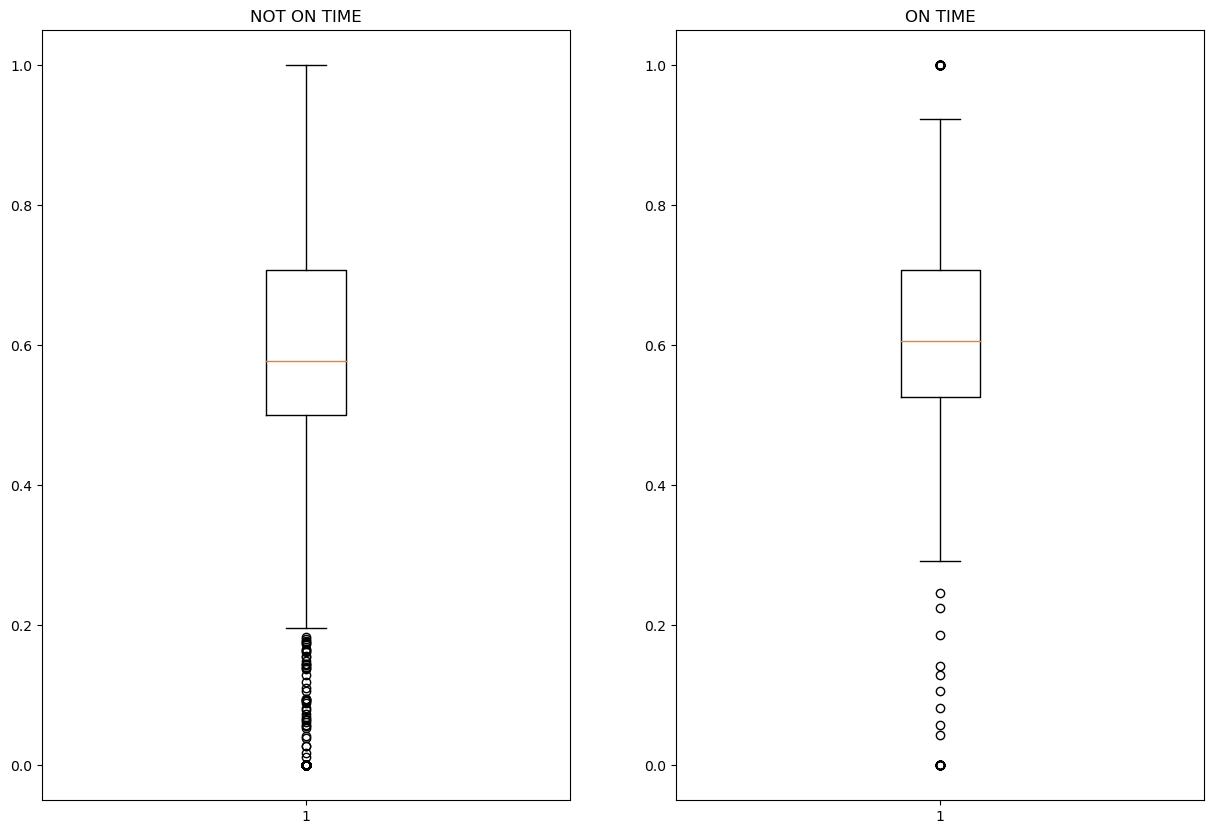

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axes[0].set_title('NOT ON TIME')
axes[0].boxplot(not_on_time)
axes[1].set_title('ON TIME')
axes[1].boxplot(on_time)

In [21]:
n1 = len(df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == True])
n2 = len(df_cpms_full_filtered[(df_cpms_full_filtered.IS_ONTIME == False) ])
s1 = np.var(df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == True].centrality)
s2 = np.var(df_cpms_full_filtered[(df_cpms_full_filtered.IS_ONTIME == False) ].centrality)
m1 = df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == True].centrality.mean()
m2 = df_cpms_full_filtered[(df_cpms_full_filtered.IS_ONTIME == False) ].centrality.mean()

In [22]:
significance(n1, n2, s1, s2, m1, m2)

The difference is significant


2.7203163396459495

In [23]:
s1 = np.var(df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == True].n_users)
s2 = np.var(df_cpms_full_filtered[(df_cpms_full_filtered.IS_ONTIME == False) ].n_users)
m1 = df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == True].n_users.mean()
m2 = df_cpms_full_filtered[(df_cpms_full_filtered.IS_ONTIME == False) ].n_users.mean()

In [24]:
significance(n1, n2, s1, s2, m1, m2)

The difference is NOT significant


-0.054023111612753624

In [25]:
csvs = os.path.abspath(os.path.join('..', 'csvs'))
df_cpms_full_filtered[['PROJECT_ID','IS_ONTIME', 'centrality']].to_csv(os.path.join(csvs,'cpms.csv'), index=True)

In [31]:
def ks_sample_test(
        sample1:np.ndarray, 
        sample2:np.ndarray):
    return ks_2samp(
        sample1, 
        sample2).pvalue

In [32]:
ks_sample_test(df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == True].centrality, 
         df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == False].centrality)

0.027228471156922323

In [33]:
ks_sample_test(df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == True].n_users,
         df_cpms_full_filtered[df_cpms_full_filtered.IS_ONTIME == False].n_users)

0.9978560048309466